## Langgraph: Search web for answer and cite source

Reference: https://github.com/langchain-ai/langchain/blob/master/docs/docs/how_to/qa_citations.ipynb

In [1]:
import dotenv
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langgraph.graph import START, StateGraph
from pydantic import BaseModel, Field

In [2]:
dotenv.load_dotenv()

True

In [3]:
system_prompt = (
    "You're a helpful AI assistant. Given a user question "
    "and some website snippets, answer the user "
    "question. If none of the websites answer the question, "
    "just say you don't know."
    "\n\nHere are the website searched: "
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

prompt.pretty_print()

================================ System Message ================================

You're a helpful AI assistant. Given a user question and some website snippets, answer the user question. If none of the websites answer the question, just say you don't know.

Here are the website searched: {context}

================================ Human Message =================================

{question}


In [4]:
model = ChatGroq(model="llama-3.3-70b-versatile")

In [5]:
# Format the answer to having a schema

class Citation(BaseModel):
    text: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )
    url: str = Field(..., description="The URL of the source")


class QuotedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the question, which is based only on the given sources.",
    )
    citation: list[Citation] = Field(
        ..., description="The citation that justifies the answer."
    )

In [6]:
class State(BaseModel):
    question: str
    context: list[dict] | None = None
    answer: QuotedAnswer | None = None

In [7]:
# Format the retrieved documents for context by concatenating them

def format_docs_with_id(docs: list[dict]) -> str:
    formatted = [
        f"Source ID: {i}\nArticle Title: {doc["title"]}\nArticle Snippet: {doc["snippet"]}\nURL: {doc["link"]}"
        for i, doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)

In [8]:
# Define the state graph for the workflow

def retrieve(
    state: State,
) -> State:
    """Retrieve relevant documents from the web."""
    search_tool = DuckDuckGoSearchResults(
        api_wrapper=DuckDuckGoSearchAPIWrapper(max_results=3),
        output_format="list",
    )
    model_with_tool = model.bind_tools([search_tool])
    tool_call = model_with_tool.invoke(state.question).tool_calls[0]
    results = search_tool.invoke(tool_call)
    state.context = results.artifact
    return state


def generate_answer(
    state: State,
) -> State:
    """Generate an answer based on the retrieved documents."""
    formatted_docs = format_docs_with_id(state.context)
    messages = prompt.invoke({"question": state.question, "context": formatted_docs})

    structured_llm = model.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(messages)
    state.answer = response
    return state

In [9]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate_answer])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

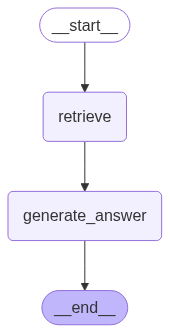

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"question": "How fast are cheetahs?"})
result["answer"]

QuotedAnswer(answer='Cheetahs are the fastest land animals, reaching speeds of 58 to 65 mph (93 to 104 km/h) and up to 75 mph (120 km/h) in short bursts.', citation=[Citation(text='The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph)', url='https://en.wikipedia.org/wiki/Cheetah'), Citation(text='Cheetahs are the fastest land animals, reaching up to 75 mph (120 km/h) in short bursts.', url='https://natureandwildlife.tv/how-fast-can-a-cheetah-run/')])

In [12]:
result

{'question': 'How fast are cheetahs?',
 'context': [{'snippet': 'Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail. The cheetah was first described in the late 18th century.',
   'title': 'Cheetah - Wikipedia',
   'link': 'https://en.wikipedia.org/wiki/Cheetah'},
  {'snippet': 'Learn how the cheetah is the fastest land animal, but not the fastest on Earth. Discover the speed champions of the air and water, and why speed varies depending on habitat and technique.',
   'title': "The Cheetah Is Not The World's Fastest Animal - WorldAtlas",
   'link': 'https://www.worldatlas.com/animals/the-cheetah-is-not-the-world-s-fastest-animal.html'},
  {'snippet': 'Cheetahs are the fastest land animals, reaching up to 75 mph (120 km/h) in short bursts. Learn about their anatomy, hunting strategy, and conservation challenges in t

Trace:

![Langsmith Trace](images/web_search_citation_langsmith_trace.png)